In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
import kagglehub
import os

dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
directory = os.path.join(dataset_path, 'PetImages')

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.


In [ ]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)

except Exception as e:
  print(f'Error: {e}')

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [ ]:
all_df.groupby("Labels").count()

,Images
Labels,
Cat,12499
Dog,12499


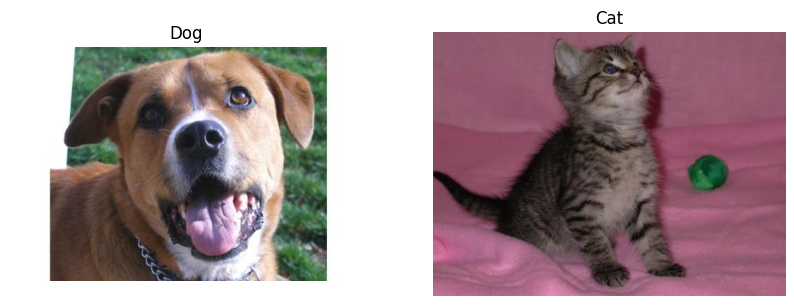

In [ ]:
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(directory, sample['Images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=111620206, stratify=all_df['Labels'])

In [ ]:
train_df_small = train_df.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
trainimgen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)




Found 19998 validated image filenames belonging to 2 classes.


In [ ]:
testimgen = ImageDataGenerator()

test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False # For test data, it's crucial to set shuffle=False. This ensures the prediction order matches the label order, which is necessary for correct evaluation with metrics like a confusion matrix.
)

Found 5000 validated image filenames belonging to 2 classes.


## Model Time

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Conv block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # For 224x224 input: after 3 poolings -> 28x28
        self.fc1 = nn.Linear(28*28*64, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
class ParameterTracker:
    # Track specific parameters during training
    def __init__(self, model, num_params_to_track=10):
        self.history = {
            'conv1_weight': [],
            'fc1_weight': [],
            'fc2_bias': [],
        }

        # Randomly select indices to track
        conv1_size = model.conv1.weight.numel()
        fc1_size = model.fc1.weight.numel()
        fc2_bias_size = model.fc2.bias.numel()

        self.indices = {
            'conv1': np.random.choice(conv1_size, num_params_to_track, replace=False),
            'fc1': np.random.choice(fc1_size, num_params_to_track, replace=False),
            'fc2_bias': np.random.choice(fc2_bias_size, min(num_params_to_track, fc2_bias_size), replace=False),
        }

    def record(self, model):
        # Conv1 weights
        weight = model.conv1.weight.detach().cpu().flatten().numpy()
        self.history['conv1_weight'].append(weight[self.indices['conv1']])

        # FC1 weights
        weight = model.fc1.weight.detach().cpu().flatten().numpy()
        self.history['fc1_weight'].append(weight[self.indices['fc1']])

        # FC2 biases
        bias = model.fc2.bias.detach().cpu().numpy()
        self.history['fc2_bias'].append(bias[self.indices['fc2_bias']])

    def plot_evolution(self):
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle('Parameter Evolution During Training', fontsize=16)

        epochs = np.arange(len(self.history['conv1_weight']))

        # Conv1 weights
        for i in range(len(self.indices['conv1'])):
            weight_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight']]
            axes[0].plot(epochs, weight_values, alpha=0.7, label=f'Weight {i}')
        axes[0].set_title('Conv1 Weight Evolution')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Weight value')
        axes[0].grid(alpha=0.3)

        # FC1 weights
        for i in range(len(self.indices['fc1'])):
            weight_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight']]
            axes[1].plot(epochs, weight_values, alpha=0.7)
        axes[1].set_title('FC1 Weight Evolution')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Weight value')
        axes[1].grid(alpha=0.3)

        # FC2 biases
        for i in range(len(self.indices['fc2_bias'])):
            bias_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias']]
            axes[2].plot(epochs, bias_values, alpha=0.7, marker='o', markersize=3)
        axes[2].set_title('FC2 Bias Evolution')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Bias value')
        axes[2].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNN().to(device)
model

Using device: cuda


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
print(f"train_data will have {len(train_data)} batches")

train_data will have 1250 batches


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/STATS/'

Mounted at /content/drive


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tracker = ParameterTracker(model, num_params_to_track=10)
tracker.record(model)

num_epochs = 30
num_batches = len(train_data)
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()

    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_data):
        if batch_idx >= num_batches:
            break

        # Convert numpy arrays to PyTorch tensors
        data = torch.FloatTensor(data).to(device)
        target = torch.LongTensor(target.astype(int)).to(device)

        # Normalize pixel values to [0, 1]
        if data.max() > 1.0:
            data = data / 255.0

        # Transpose from (batch, height, width, channels) to (batch, channels, height, width)
        data = data.permute(0, 3, 1, 2)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_data)
    train_losses.append(avg_loss)

    tracker.record(model)

    # ============ VALIDATION ACCURACY ============
    # Calculate validation accuracy every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_data):
                if batch_idx >= len(test_data):
                    break

                data = torch.FloatTensor(data).to(device)
                target = torch.LongTensor(target.astype(int)).to(device)

                if data.max() > 1.0:
                    data = data / 255.0

                data = data.permute(0, 3, 1, 2)

                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)

                total += target.size(0)
                correct += (predicted == target).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'  Validation Accuracy: {val_accuracy:.2f}%')

    # Save checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
        }, f'{save_dir}/checkpoint_epoch_{epoch+1}_standard.pth')
        print(f"Checkpoint saved at epoch {epoch+1}")

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Loss: {avg_loss:.4f}')


# Save the final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_accuracies': val_accuracies,
    'tracker_history': tracker.history,
}, f'{save_dir}/standard_cnn_catdog.pth')

print("Model saved as 'standard_cnn_catdog.pth'")


Epoch 1/30:
  Loss: 0.3577


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  Validation Accuracy: 85.62%
Epoch 2/30:
  Loss: 0.3427
Epoch 3/30:
  Loss: 0.3357
  Validation Accuracy: 85.06%
Epoch 4/30:
  Loss: 0.3298
Checkpoint saved at epoch 5
Epoch 5/30:
  Loss: 0.3233
  Validation Accuracy: 86.20%
Epoch 6/30:
  Loss: 0.3189
Epoch 7/30:
  Loss: 0.3089
  Validation Accuracy: 85.82%
Epoch 8/30:
  Loss: 0.3016
Epoch 9/30:
  Loss: 0.2968
  Validation Accuracy: 86.22%
Checkpoint saved at epoch 10
Epoch 10/30:
  Loss: 0.2974
Epoch 11/30:
  Loss: 0.2866
  Validation Accuracy: 86.74%
Epoch 12/30:
  Loss: 0.2861
Epoch 13/30:
  Loss: 0.2784
  Validation Accuracy: 85.56%
Epoch 14/30:
  Loss: 0.2770
Checkpoint saved at epoch 15
Epoch 15/30:
  Loss: 0.2761
  Validation Accuracy: 86.70%
Epoch 16/30:
  Loss: 0.2684
Epoch 17/30:
  Loss: 0.2645
  Validation Accuracy: 87.74%
Epoch 18/30:
  Loss: 0.2564
Epoch 19/30:
  Loss: 0.2588
  Validation Accuracy: 87.18%
Checkpoint saved at epoch 20
Epoch 20/30:
  Loss: 0.2485
Epoch 21/30:
  Loss: 0.2553
  Validation Accuracy: 88.10%
Epo

In [ ]:
# Plot training loss and validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(range(1, num_epochs + 1), train_losses, marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)

# Plot validation accuracy
val_epochs = list(range(2, num_epochs + 1, 2))
ax2.plot(val_epochs, val_accuracies, marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Validation Accuracy over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%"

SyntaxError: incomplete input (ipython-input-1701479372.py, line 23)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

# Load the checkpoint
checkpoint = torch.load(f'{save_dir}/checkpoint_epoch_10_standard.pth')

# Extract and load only the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# ============ PREDICTIONS ============

# Prepare test data by converting from ImageDataGenerator to numpy arrays
print("Converting test data to numpy arrays...")
X_test = []
y_test = []

for batch_idx, (data, target) in enumerate(test_data):
    X_test.append(data)
    y_test.append(target)

    # Break after we've gone through all batches
    if batch_idx >= len(test_data) - 1:
        break

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


Converting test data to numpy arrays...
Test data shape: (5000, 224, 224, 3)
Test labels shape: (5000,)


Making predictions in batches...
  Processed 0/5000 images...
  Processed 320/5000 images...
  Processed 640/5000 images...
  Processed 960/5000 images...
  Processed 1280/5000 images...
  Processed 1600/5000 images...
  Processed 1920/5000 images...
  Processed 2240/5000 images...
  Processed 2560/5000 images...
  Processed 2880/5000 images...
  Processed 3200/5000 images...
  Processed 3520/5000 images...
  Processed 3840/5000 images...
  Processed 4160/5000 images...
  Processed 4480/5000 images...
  Processed 4800/5000 images...

Predictions complete! Shape: (5000,)


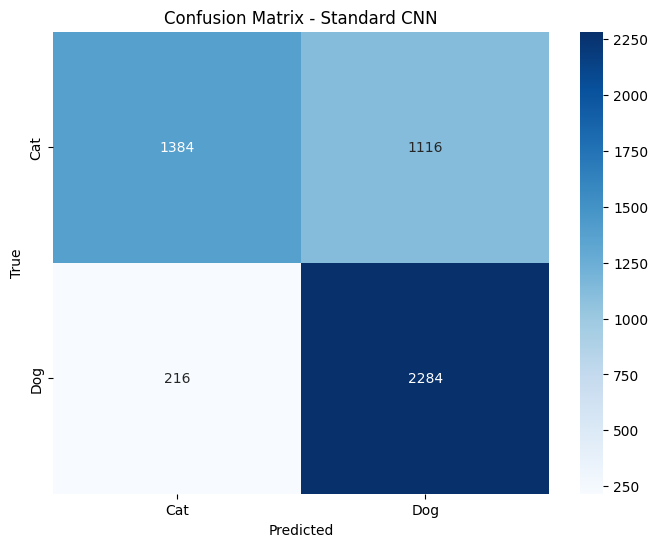

              precision    recall  f1-score   support

         Cat       0.86      0.55      0.68      2500
         Dog       0.67      0.91      0.77      2500

    accuracy                           0.73      5000
   macro avg       0.77      0.73      0.72      5000
weighted avg       0.77      0.73      0.72      5000



In [ ]:
# Make predictions in batches to avoid OOM
model.eval()
y_pred_list = []
batch_size = 32  # Adjust this if you still get OOM errors

print("Making predictions in batches...")
with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        # Get batch
        batch_end = min(i + batch_size, len(X_test))
        batch_data = X_test[i:batch_end]

        # Convert to tensor and move to GPU
        batch_tensor = torch.FloatTensor(batch_data).permute(0, 3, 1, 2).to(device)

        # Make predictions
        outputs = model(batch_tensor)
        _, batch_pred = torch.max(outputs, 1)

        # Move predictions back to CPU and store
        y_pred_list.extend(batch_pred.cpu().numpy())

        # Clear GPU memory
        del batch_tensor, outputs, batch_pred
        torch.cuda.empty_cache()

        if (i // batch_size) % 10 == 0:
            print(f"  Processed {i}/{len(X_test)} images...")

y_pred = np.array(y_pred_list)
y_test_true = y_test.astype(int)

print(f"\nPredictions complete! Shape: {y_pred.shape}")

# Print confusion matrix
cm = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Standard CNN')
plt.show()

# Print classification report
print(classification_report(y_test_true, y_pred,
                          target_names=['Cat', 'Dog']))


Test Accuracy: 0.7336
Total misclassified: 1332


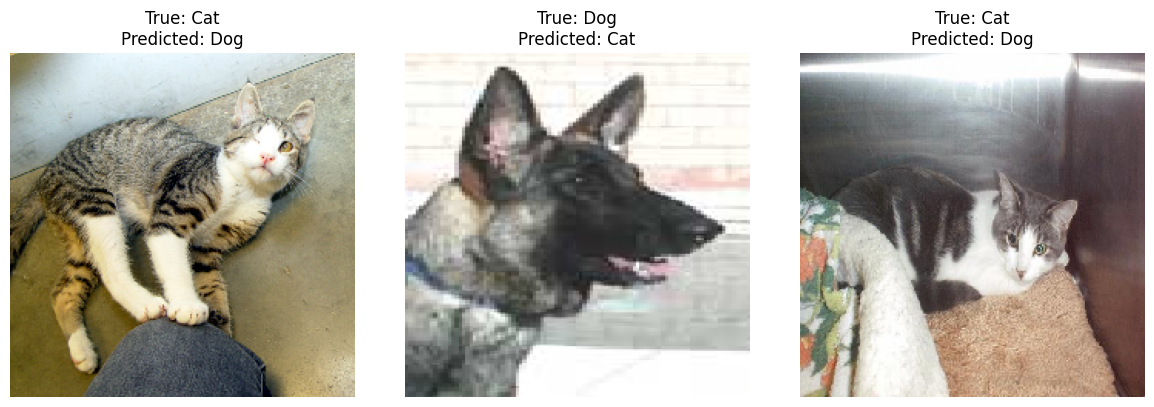


Total correct: 3668


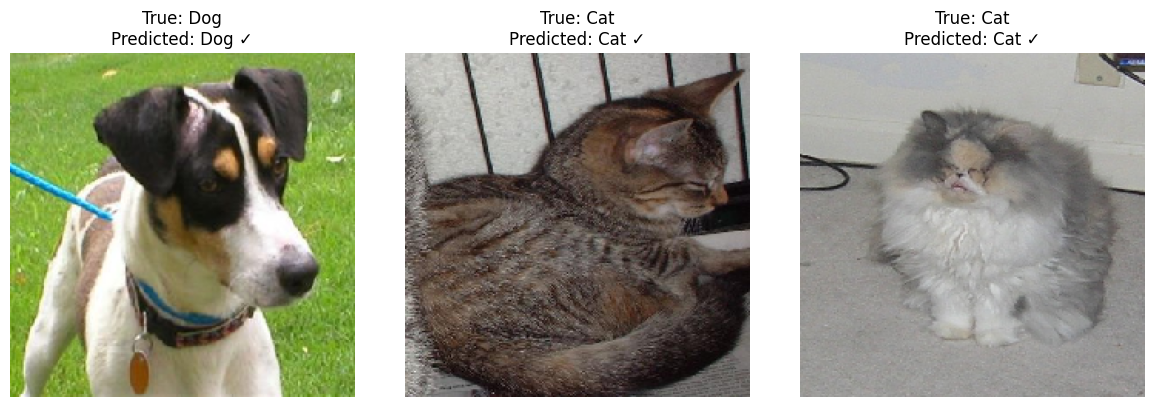

In [ ]:

# Calculate accuracy
accuracy = (y_pred == y_test_true).mean()
print(f"\nTest Accuracy: {accuracy:.4f}")

# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test_true)[0]

print(f"Total misclassified: {len(misclassified_idx)}")

# Select 3 random misclassified examples
n_examples = min(3, len(misclassified_idx))
random_idx = np.random.choice(misclassified_idx, n_examples, replace=False)

# Plot the misclassified images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

class_names = ['Cat', 'Dog']

for i, idx in enumerate(random_idx):
    # Convert from channels-first back to channels-last for visualization
    img = X_test[idx].astype(np.uint8)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Visualize some correct predictions too
correct_idx = np.where(y_pred == y_test_true)[0]
print(f"\nTotal correct: {len(correct_idx)}")

# Select 3 random correct examples
n_correct = min(3, len(correct_idx))
correct_random_idx = np.random.choice(correct_idx, n_correct, replace=False)

# Plot the correctly classified images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(correct_random_idx):
    img = X_test[idx].astype(np.uint8)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]} ✓")
    axes[i].axis('off')

plt.tight_layout()
plt.show()